-------------
# １．ライブラリのインポート

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

import time

--------
# ２．実験設定

## 2.1 実験設定

In [2]:
### 実験データの設定 ###
TARGET = "GMV"  # "GMV" or "BCR"（目的変数）
DATA = "part"  # "all" or "part"（データすべてを使うか一部を使うか）
DATA_SIZE = 20000  # 訓練データとテストデータあわせたデータサイズ（母集団サイズ）
TEST_SIZE = 0.5  # テストデータの比率
THRESHOLD = 2  # 外れ値除外のための閾値


### 実験設定 ###
SAMPLE_SIZE = 100  # 標本サイズ
N_TRIALS = 10000  # 試行回数（標本抽出を行う回数）
m_VALUE = 2  # 最適標本配分における各クラスタの最小標本数
RANDOM_STATE = 0  # 乱数シード
SEED = 0

### 実験方法 ###
# クラスタリング
CLUSTERING_METHOD_LIST = ["kmeans"]  # ["gmm", "kmeans", "xmeans"]
N_CLUSTERS = 10  # クラスタ数（Kmeans と GMM）
K_MIN = 2  # 最小クラスタ数（Xmeans)
K_MAX = 10  # 最大クラスタ数(Xmeans)

# 特徴量選択
CRITERION_LIST = [
    "none",
    "lasso",  # "lasso" を選択した場合はalphaも調節する
    "ml",
    "ml(obj)",
    # "checking"
]
LASSO_ALPHA = 10  # 選ばれる特徴量の数を確認して調節
SELECT_MAXIMUM_FEATURES = "yes"  # "yes" or "no"（特徴量数が MAXIMUM_FEATURES_TO_SELECT になるまで選ぶかいなか）
MAXIMUM_FEATURES_TO_SELECT = 5  # 選択される最大の特徴量(特徴量選択ありの場合)
FEATURES_LIST_CHECKING = [0]  # 特徴量を指定するとき（特徴量選択基準："checking"の場合)

# 標本配分
ALLOCATION_LIST = [
    "Proportional",
    "Post",
    "Optimal",
]


### 可視化 ###
TITLE_SIZE = 20
LABEL_SIZE = 15
TICK_SIZE = 12.5

## 2.2 各手法の名前

In [3]:
stratification_methods = list(itertools.product(CRITERION_LIST, CLUSTERING_METHOD_LIST))
METHODS_NAME_DICT = {}
for method in stratification_methods:
    if method == ("none", "kmeans"):
        METHODS_NAME_DICT[method] = "Kmeans"
    if method == ("none", "xmeans"):
        METHODS_NAME_DICT[method] = "Xmeans"
    if method == ("none", "gmm"):
        METHODS_NAME_DICT[method] = "GMM"

    if method == ("ml", "kmeans"):
        METHODS_NAME_DICT[method] = "SFS-Kmeans-TSS"
    if method == ("ml", "xmeans"):
        METHODS_NAME_DICT[method] = "SFS-Xmeans-TSS"
    if method == ("ml", "gmm"):
        METHODS_NAME_DICT[method] = "SFS-GMM-Loglikelyhood"

    if method == ("checking", "kmeans"):
        METHODS_NAME_DICT[method] = f"Kmeans ({FEATURES_LIST_CHECKING})"
    if method == ("checking", "xmeans"):
        METHODS_NAME_DICT[method] = f"Xmeans ({FEATURES_LIST_CHECKING})"
    if method == ("checking", "gmm"):
        METHODS_NAME_DICT[method] = f"GMM ({FEATURES_LIST_CHECKING})"

    if method == ("lasso", "kmeans"):
        METHODS_NAME_DICT[method] = "Lasso-Kmeans"
    if method == ("lasso", "xmeans"):
        METHODS_NAME_DICT[method] = "Lasso-Xmeans"
    if method == ("lasso", "gmm"):
        METHODS_NAME_DICT[method] = "Lasso-GMM"

    if method == ("ml(obj)", "kmeans"):
        METHODS_NAME_DICT[method] = "SFS-Kmeans-TSST"
    if method == ("ml(obj)", "xmeans"):
        METHODS_NAME_DICT[method] = "SFS-Xmeans-TSST"

print("METHODS_NAME_DICT", METHODS_NAME_DICT)

METHODS_NAME_DICT {('none', 'kmeans'): 'Kmeans', ('lasso', 'kmeans'): 'Lasso-Kmeans', ('ml', 'kmeans'): 'SFS-Kmeans-TSS', ('ml(obj)', 'kmeans'): 'SFS-Kmeans-TSST'}


-----------
# ３．データの前処理

## 3.1 データ読み込み

In [4]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)

features_list = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]

if DATA == "all":
    df = df1
if DATA == "part":
    df = df2

ALL_FEATURES_INDEX = [i for i in range(len(features_list))]
print(ALL_FEATURES_INDEX)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


## 3.2 "GMV" から新しい変数 "BCR" を作成

In [5]:
df = df.copy()
df["BCR"] = np.where(df["GMV"] > 0, 1, 0)

## 3.3 外れ値除去

In [6]:
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

In [7]:
df = remove_outliers_zscore(data=df, metric=TARGET, threshold=THRESHOLD)
df = df.reset_index(drop=True)  # 行を詰める

print("外れ値除外前のデータ数（訓練+テスト）:", DATA_SIZE)
print("外れ値除外後のデータ数（訓練+テスト）:", len(df))

外れ値除外前のデータ数（訓練+テスト）: 20000
外れ値除外後のデータ数（訓練+テスト）: 19801


## 3.4 訓練データとテストデータに分割

In [8]:
X_all = df[features_list].to_numpy()
y_all = df[TARGET].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("訓練データのデータ数:", len(X_train))
print("テストデータのデータ数:", len(X_test))

訓練データのデータ数: 9900
テストデータのデータ数: 9901


## 3.5 標準化

In [9]:
sc = StandardScaler()
# 訓練データに基づいてfit
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


-------------
# 4. 特徴量選択

In [10]:
TIME_DICT = {}
SELECTED_FEATURES_DICT = {}


## 4.1 特徴量選択なしの場合

In [11]:
for method, name in METHODS_NAME_DICT.items():
    if method[0] == "none":
        SELECTED_FEATURES_DICT[name] = np.array(ALL_FEATURES_INDEX)
        TIME_DICT[name] = 0
    if method[0] == "checking":
        SELECTED_FEATURES_DICT[name] = np.array(FEATURES_LIST_CHECKING)
        TIME_DICT[name] = 0


## 4.2 Lasso で特徴量選択する場合

In [12]:
def lasso(X: NDArray, y: NDArray, alpha: float) -> list:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    features_list = np.where(lasso.coef_ != 0)[0]
    return features_list

In [13]:
if "lasso" in CRITERION_LIST:
    start_time = time.time()
    selected_features_index = lasso(X_train_std, y_train, alpha=LASSO_ALPHA)
    end_time = time.time()

    for method, name in METHODS_NAME_DICT.items():
        if method[0] == "lasso":
            SELECTED_FEATURES_DICT[name] = selected_features_index
            TIME_DICT[name] = end_time - start_time

    print(selected_features_index)


[ 0  1  3  4  5  6  7  8  9 14 16]


## 4.3 Wrapper法 で特徴量選択する場合

### 準備

In [14]:
class Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        maximum_features_to_select: int,
        n_clusters: int,
        criterion: str = "ml",
        clustering_method: str = "gmm",
        random_state: int = 0,
        select_maximum_features: str = "yes",
        k_min: int = 2,
        k_max: int = 10,
    ):
        self.maximum_features_to_select = maximum_features_to_select  # 特徴量数
        self.n_clusters = n_clusters  # クラスタ数
        self.criterion = criterion  # 特徴量選択基準
        self.clustering_method = clustering_method  # クラスタリング手法
        self.random_state = random_state
        self.select_maximum_features = select_maximum_features
        self.k_min = k_min
        self.k_max = k_max

    def fss(self, X: NDArray, y: NDArray) -> "Wrapper":
        X, y = check_X_y(X, y)
        n_all_features = X.shape[1]  # 総特徴量数

        ##### 初期化 #####
        features_score_dict = {}  # スコアの推移の確認用（キー：特徴量の数, 値：スコア）
        current_features = []  # 選択された特徴量
        remaining_features = list(range(n_all_features))  # 選択されていない特徴量

        if self.select_maximum_features == "no":
            best_score = -np.inf  # 初期スコア（特徴量を最大数選ぶとは限らないとき）

        ##### 特徴量選択とクラスタリング #####
        while len(current_features) < self.maximum_features_to_select:
            best_feature = None

            if self.select_maximum_features == "yes":
                best_score = -np.inf  # 初期スコア（特徴量を最大数選ぶとき）

            for feature in remaining_features:
                temp_features = current_features + [
                    feature
                ]  # スコアを調べたい特徴量サブセット

                score, labels = self.crit(X[:, temp_features], y)
                if score > best_score:
                    best_score = score
                    best_feature = feature
                    best_labels = np.array(labels)
                    best_cluster_size = np.bincount(best_labels)
                    best_n_clusters = len(np.unique(best_labels))

            # 選択された特徴量をcurrent_featuresに追加し、remaining_features から除外
            if best_feature is not None:
                current_features.append(best_feature)
                remaining_features.remove(best_feature)
                num_of_features = len(current_features)
                print(
                    "num_of_features:",
                    num_of_features,
                    "current_features:",
                    current_features,
                    ", score:",
                    best_score,
                    "best_n_clusters:",
                    best_n_clusters,
                    "best_cluster_size",
                    best_cluster_size,
                )
                features_score_dict[str(num_of_features)] = best_score  # 確認用

            else:
                break

        ##### 最終的な特徴量とクラスタリング結果 #####
        self.selected_features_index = current_features
        self.features_score_dict = features_score_dict

        return self

    def crit(self, X: NDArray, y: NDArray) -> tuple[float, list, int]:
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            model = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
        if self.clustering_method == "kmeans":
            model = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )
        if self.clustering_method == "xmeans":
            model = self.xmeans(X)

        model.fit(X)
        labels = model.predict(X)

        if self.criterion == "ml":
            score = model.score(X)

        elif self.criterion == "sil":
            score = silhouette_score(X, labels)

        elif self.criterion == "ml(obj)" and (
            self.clustering_method == "kmeans" or self.clustering_method == "xmeans"
        ):
            tss = 0
            for k in np.unique(labels):
                y_k = y[labels == k]
                mean_y_k = np.mean(y_k)
                tss += np.sum((y_k - mean_y_k) ** 2)
            score = -tss

        return score, labels

    def compute_bic(self, X: NDArray, kmeans: KMeans) -> float:
        # クラスタリング結果の取得
        labels = kmeans.labels_
        clusters = kmeans.cluster_centers_
        n_clusters = len(clusters)
        n = len(X)
        m = X.shape[1]
        # クラスター内の分散の合計
        variance = np.sum(
            [
                np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
                for i in range(n_clusters)
            ]
        )
        # BIC の計算
        bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
        return bic

    def xmeans(self, X: NDArray) -> KMeans:
        kmeans = KMeans(
            n_clusters=self.k_min, random_state=self.random_state
        )  # 初期クラスター数で KMeans を実行
        kmeans.fit(X)
        best_bic = self.compute_bic(X, kmeans)
        best_kmeans = kmeans
        for k in range(self.k_min + 1, self.k_max + 1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            kmeans.fit(X)
            # BIC を計算
            current_bic = self.compute_bic(X, kmeans)
            # BIC が改善される場合、クラスタ数を更新
            if current_bic < best_bic:
                best_bic = current_bic
                best_kmeans = kmeans
        # 最適なクラスタリング結果を返す
        return best_kmeans

    def get_selected_features_index(self) -> list:
        return self.selected_features_index  # 最終的に選択された特徴量のインデックス

    def get_features_score_dict(self) -> dict:
        return self.features_score_dict  # スコアの推移（確認用）

In [15]:
def process_wrapper(instance: "Wrapper", X: NDArray, y: NDArray) -> tuple[list, dict]:
    instance.fss(X, y)
    selected_features_index = instance.get_selected_features_index()
    features_score_dict = instance.get_features_score_dict()
    selected_features_index = np.array(selected_features_index)

    return selected_features_index, features_score_dict

### インスタンスのリスト作成

In [16]:
instances = []
for method, name in METHODS_NAME_DICT.items():
    if method[0] == "ml" or method[0] == "ml(obj)":
        instances.append(
            (
                name,
                Wrapper(
                    maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
                    n_clusters=N_CLUSTERS,
                    criterion=method[0],
                    clustering_method=method[1],
                    random_state=RANDOM_STATE,
                    select_maximum_features=SELECT_MAXIMUM_FEATURES,
                    k_min=K_MIN,
                    k_max=K_MAX,
                ),
            )
        )
print(instances)


[('SFS-Kmeans-TSS', Wrapper(clustering_method='kmeans', maximum_features_to_select=5, n_clusters=10)), ('SFS-Kmeans-TSST', Wrapper(clustering_method='kmeans', criterion='ml(obj)',
        maximum_features_to_select=5, n_clusters=10))]


### Wrapper 法実施

In [17]:
features_score_dict_dict = {}

# 各インスタンスに対して処理を実行
for method_name, instance in instances:
    print("[", method_name, "]")
    start_time = time.time()
    selected_features_index, features_score_dict = process_wrapper(
        instance, X_train_std, y_train
    )
    end_time = time.time()

    SELECTED_FEATURES_DICT[method_name] = selected_features_index
    TIME_DICT[method_name] = end_time - start_time

    features_score_dict[method_name]=features_score_dict

[ SFS-Kmeans-TSS ]


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


num_of_features: 1 current_features: [2] , score: -6.871409892782556e-25 best_n_clusters: 2 best_cluster_size [5075 4825]
num_of_features: 2 current_features: [2, 6] , score: -27.128357838082145 best_n_clusters: 10 best_cluster_size [2189 1009 1014 1183  332 1521  282  922  781  667]
num_of_features: 3 current_features: [2, 6, 10] , score: -739.4671539966319 best_n_clusters: 10 best_cluster_size [2354 1467  364 2081  145 1723  303  475  634  354]
num_of_features: 4 current_features: [2, 6, 10, 7] , score: -2333.910583773477 best_n_clusters: 10 best_cluster_size [2382 2199  190  637 1706  145  347 1740  243  311]
num_of_features: 5 current_features: [2, 6, 10, 7, 8] , score: -4027.405496224349 best_n_clusters: 10 best_cluster_size [4131 2208  255 1730   38  369  654    2  348  165]
[ SFS-Kmeans-TSST ]


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


num_of_features: 1 current_features: [5] , score: -173161034155.28122 best_n_clusters: 10 best_cluster_size [2412   42  552    3  112    9  212   32 1084 5442]
num_of_features: 2 current_features: [5, 3] , score: -170223035962.18375 best_n_clusters: 10 best_cluster_size [3572  449   27   81 1500 3378  662    5  205   21]
num_of_features: 3 current_features: [5, 3, 4] , score: -172792441303.58557 best_n_clusters: 10 best_cluster_size [3412 1628   36  206 3406   12  104  659   42  395]
num_of_features: 4 current_features: [5, 3, 4, 1] , score: -172081632260.37396 best_n_clusters: 10 best_cluster_size [3284   37  302    5  181   22 1203    1 4738  127]
num_of_features: 5 current_features: [5, 3, 4, 1, 15] , score: -171994779217.79547 best_n_clusters: 10 best_cluster_size [5472  250  114   48 1006   24    3   34 2800  149]


## 4.4 特徴量選択の結果

### Wrapper 法のスコア推移

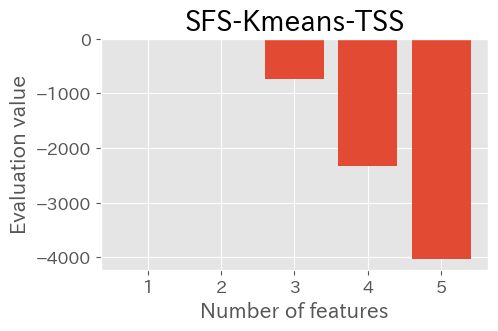

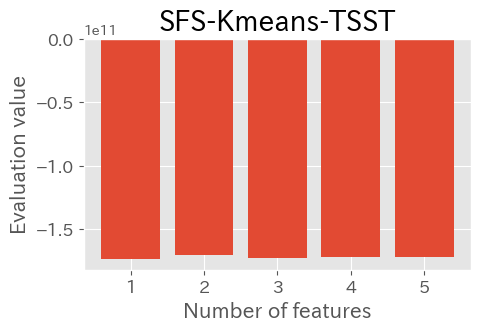

In [18]:
for method_name, instance in instances:
    # 棒グラフを作成
    plt.figure(figsize=(5, 3))
    plt.bar(features_score_dict_dict[method_name].keys(), features_score_dict_dict[method_name].values())
    plt.title(f"{method_name}", fontsize=TITLE_SIZE)
    plt.xlabel("Number of features", fontsize=LABEL_SIZE)
    plt.ylabel("Evaluation value", fontsize=LABEL_SIZE)
    # plt.ylim(,)
    plt.tick_params(axis="both", labelsize=TICK_SIZE)
    plt.show()


### 特徴量選択の結果

In [19]:
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    print("選択された特徴量：", SELECTED_FEATURES_DICT[method_name])
    print(f"特徴量選択にかかった時間：{round(TIME_DICT[method_name], 3)} s")
    print()


【Kmeans】
選択された特徴量： [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
特徴量選択にかかった時間：0 s

【Lasso-Kmeans】
選択された特徴量： [ 0  1  3  4  5  6  7  8  9 14 16]
特徴量選択にかかった時間：0.008 s

【SFS-Kmeans-TSS】
選択された特徴量： [ 2  6 10  7  8]
特徴量選択にかかった時間：2.799 s

【SFS-Kmeans-TSST】
選択された特徴量： [ 5  3  4  1 15]
特徴量選択にかかった時間：1.096 s



-----------
# 5. クラスタリングと標本配分

## 5.1 クラスタリング

### 準備

In [20]:
def compute_bic(X: NDArray, kmeans: KMeans) -> float:
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X: NDArray, k_min: int, k_max: int) -> KMeans:
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_kmeans = kmeans
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        if current_bic < best_bic:
            best_bic = current_bic
            best_kmeans = kmeans
    return best_kmeans


In [21]:
def clustering(
    X: NDArray,
    methods_name_dict: dict,
    n_clusters: int,
    random_state: int,
    k_min: int,
    k_max: int,
    selected_features_dict: dict,
) -> tuple[dict, dict, dict]:
    cluster_label_dict = {}
    cluster_size_dict = {}
    n_clusters_dict = {}

    for method, name in methods_name_dict.items():
        if method[1] == "kmeans":
            model = KMeans(n_clusters=n_clusters, random_state=random_state)
        if method[1] == "gmm":
            model = GaussianMixture(
                n_components=n_clusters, random_state=random_state, init_params="kmeans"
            )
        if method[1] == "xmeans":
            model = xmeans(X, k_min=k_min, k_max=k_max)

        labels = model.fit_predict(X[:, selected_features_dict[name]])
        cluster_size = np.bincount(labels)
        n_clusters = len(np.unique(labels))

        cluster_label_dict[name] = labels
        cluster_size_dict[name] = cluster_size
        n_clusters_dict[name] = n_clusters

    return cluster_label_dict, cluster_size_dict, n_clusters_dict


### クラスタリングの実施

In [22]:
CLUSTER_LABEL_DICT_TRAIN, CLUSTER_SIZE_DICT_TRAIN, N_CLUSTERS_DICT_TRAIN = clustering(
    X=X_train_std,
    methods_name_dict=METHODS_NAME_DICT,
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    k_min=K_MIN,
    k_max=K_MAX,
    selected_features_dict=SELECTED_FEATURES_DICT,
)

CLUSTER_LABEL_DICT_TEST, CLUSTER_SIZE_DICT_TEST, N_CLUSTERS_DICT_TEST = clustering(
    X=X_test_std,
    methods_name_dict=METHODS_NAME_DICT,
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    k_min=K_MIN,
    k_max=K_MAX,
    selected_features_dict=SELECTED_FEATURES_DICT,
)

### クラスタリング結果

In [24]:
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    print(f"訓練データでの各層のクラスタサイズ：{CLUSTER_SIZE_DICT_TRAIN[method_name]}")
    print(
        f"テストデータでの各層のクラスタサイズ：{CLUSTER_SIZE_DICT_TEST[method_name]}"
    )


【Kmeans】
訓練データでの各層のクラスタサイズ：[ 646  663   17 3366  161   27  319  989 1001 2711]
テストデータでの各層のクラスタサイズ：[ 646 2307 1482 1456 2811  782    1    5  345   66]
【Lasso-Kmeans】
訓練データでの各層のクラスタサイズ：[1828  114  688   11 4219  430    3  282  170 2155]
テストデータでの各層のクラスタサイズ：[ 666 3468 1934   29  262   52    4  357 1936 1193]
【SFS-Kmeans-TSS】
訓練データでの各層のクラスタサイズ：[4131 2208  255 1730   38  369  654    2  348  165]
テストデータでの各層のクラスタサイズ：[3970  163 2151  180  463 1822   83  332  407  330]
【SFS-Kmeans-TSST】
訓練データでの各層のクラスタサイズ：[5472  250  114   48 1006   24    3   34 2800  149]
テストデータでの各層のクラスタサイズ：[5731  169    4  176   10 2763  115    7  891   35]


## 5.2 標本配分

### 基底クラス

In [25]:
class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(
        self,
        sample_size: int,
        random_state: int,
        method_name: str,
        cluster_label_dict: dict,
        cluster_size_dict: dict,
        n_clusters_dict: dict,
    ):
        self.sample_size = sample_size
        self.random_state = random_state
        self.method_name = method_name

        self.cluster_label = cluster_label_dict[self.method_name]
        self.N = cluster_size_dict[self.method_name]
        self.H = n_clusters_dict[self.method_name]

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError


### ① 比例配分（Proportional）

In [26]:
class Proportional(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.sample_size).astype(int)

        if n.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.sample_size

        if n.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n[np.argmax(n)] += -n.sum() + self.sample_size

        return n


### ② 事後層化（Post）

In [27]:
class Post(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.sample_size])

        return n  # （例）n=[標本サイズ]


### ③ 最適標本配分（Optimal）

In [28]:
class Optimal(BaseAllocation):
    def __init__(
        self,
        sample_size: int,
        random_state: int,
        method_name: str,
        cluster_label_dict: dict,
        cluster_size_dict: dict,
        n_clusters_dict: dict,
        m: NDArray,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
    ):
        super().__init__(
            sample_size,
            random_state,
            method_name,
            cluster_label_dict,
            cluster_size_dict,
            n_clusters_dict,
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.m = m  # 各クラスタの最小標本サイズ (H, )
        self.M = M  # 各クラスタの最大標本サイズ (H, ), (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in range(self.H)])
        d = (self.N**2) * S  # (H, )
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N.copy()
        I = np.arange(self.H)  # noqa #クラスタのインデックス
        while (n.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(n >= self.m), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"


### ポリシーの作成

In [35]:
def create_policies(
    sample_size: int,
    random_state: int,
    m_value: int,
    methods_name_dict: dict,
    cluster_label_dict: dict,
    cluster_size_dict: dict,
    n_clusters_dict: dict,
    allocation_list: list,
) -> dict[list[BaseAllocation]]:
    policies_dict = {}

    for _, method_name in methods_name_dict.items():
        policies: list[BaseAllocation] = []
        if "Proportional" in allocation_list:
            policies.append(
                Proportional(
                    sample_size=sample_size,
                    random_state=random_state,
                    method_name=method_name,
                    cluster_label_dict=cluster_label_dict,
                    cluster_size_dict=cluster_size_dict,
                    n_clusters_dict=n_clusters_dict,
                )
            )
        if "Post" in allocation_list:
            policies.append(
                Post(
                    sample_size=sample_size,
                    random_state=random_state,
                    method_name=method_name,
                    cluster_label_dict=cluster_label_dict,
                    cluster_size_dict=cluster_size_dict,
                    n_clusters_dict=n_clusters_dict,
                )
            )
        if "Optimal" in allocation_list:
            policies.append(
                Optimal(
                    sample_size=sample_size,
                    random_state=random_state,
                    method_name=method_name,
                    cluster_label_dict=cluster_label_dict,
                    cluster_size_dict=cluster_size_dict,
                    n_clusters_dict=n_clusters_dict,
                    m=np.full(n_clusters_dict[method_name], m_value),
                    M=None,
                )
            )
        policies_dict[method_name] = policies

    return policies_dict


In [36]:
policies_dict_train = create_policies(
    sample_size=SAMPLE_SIZE,
    random_state=RANDOM_STATE,
    m_value=m_VALUE,
    methods_name_dict=METHODS_NAME_DICT,
    cluster_label_dict=CLUSTER_LABEL_DICT_TRAIN,
    cluster_size_dict=CLUSTER_SIZE_DICT_TRAIN,
    n_clusters_dict=N_CLUSTERS_DICT_TRAIN,
    allocation_list=ALLOCATION_LIST,
)

policies_dict_test = create_policies(
    sample_size=SAMPLE_SIZE,
    random_state=RANDOM_STATE,
    m_value=m_VALUE,
    methods_name_dict=METHODS_NAME_DICT,
    cluster_label_dict=CLUSTER_LABEL_DICT_TEST,
    cluster_size_dict=CLUSTER_SIZE_DICT_TEST,
    n_clusters_dict=N_CLUSTERS_DICT_TEST,
    allocation_list=ALLOCATION_LIST,
)


### 標本配分の実施

In [37]:
def cauculate_allocation_dict_dict(
    X: NDArray, y: NDArray, policies_dict: dict
) -> dict[dict]:
    allocation_dict_dict = {}
    for name, policies in policies_dict.items():
        # それぞれの戦略で各クラスタの標本数を求解
        allocation_dict = {}
        for policy in policies:
            n = policy.solve(X, y)
            allocation_dict[policy.__class__.__name__] = n
        allocation_dict_dict[name] = allocation_dict
    return allocation_dict_dict


In [39]:
ALLOCATION_DICT_DICT_TRAIN = cauculate_allocation_dict_dict(
    X=X_train_std, y=y_train, policies_dict=policies_dict_train
)
ALLOCATION_DICT_DICT_TEST = cauculate_allocation_dict_dict(
    X=X_test_std, y=y_test, policies_dict=policies_dict_test
)


### 標本配分の結果

In [40]:
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    for allocation_method in ALLOCATION_LIST:
        print(
            f"訓練データでの標本配分 ({allocation_method}) : {ALLOCATION_DICT_DICT_TRAIN[method_name][allocation_method]}"
        )
        print(
            f"テストデータでの標本配分 ({allocation_method}) : {ALLOCATION_DICT_DICT_TEST[method_name][allocation_method]}"
        )
    print()


【Kmeans】
訓練データでの標本配分 (Proportional) : [ 7  7  0 34  2  0  3 10 10 27]
テストデータでの標本配分 (Proportional) : [ 7 23 15 15 28  8  0  0  3  1]
訓練データでの標本配分 (Post) : [100]
テストデータでの標本配分 (Post) : [100]
訓練データでの標本配分 (Optimal) : [ 7  4  2 28  4  2  4  8 14 27]
テストデータでの標本配分 (Optimal) : [ 4 22 14 15 21 14  2  2  4  2]
【Lasso-Kmeans】
訓練データでの標本配分 (Proportional) : [18  1  7  0 43  4  0  3  2 22]
テストデータでの標本配分 (Proportional) : [ 7 33 20  0  3  1  0  4 20 12]
訓練データでの標本配分 (Post) : [100]
テストデータでの標本配分 (Post) : [100]
訓練データでの標本配分 (Optimal) : [13  3  4  2 36  5  2  6  2 27]
テストデータでの標本配分 (Optimal) : [ 4 28 15  2  6  2  2  4 20 17]
【SFS-Kmeans-TSS】
訓練データでの標本配分 (Proportional) : [41 22  3 17  0  4  7  0  4  2]
テストデータでの標本配分 (Proportional) : [40  2 22  2  5 18  1  3  4  3]
訓練データでの標本配分 (Post) : [100]
テストデータでの標本配分 (Post) : [100]
訓練データでの標本配分 (Optimal) : [49 19  3 11  2  3  7  2  2  2]
テストデータでの標本配分 (Optimal) : [47  2 19  2  5 14  2  2  3  4]
【SFS-Kmeans-TSST】
訓練データでの標本配分 (Proportional) : [56  3  1  0 10  0  0  0 28  2]
テストデータで

---------------
# 6. 評価

## 6.1 標本平均の分散を計算（単純無作為抽出）

In [41]:
def cauculate_var_random(y: NDArray, seed: int, n_trials: int, sample_size) -> float:
    np.random.seed(seed)
    y_hats = []
    for i in range(n_trials):
        sample = np.random.choice(y, sample_size, replace=False)
        y_hat_random = sample.mean()
        y_hats.append(y_hat_random)
    var_random = np.array(y_hats).var()

    return var_random


In [42]:
VAR_RANDOM_TRAIN = cauculate_var_random(
    y=y_train, seed=SEED, n_trials=N_TRIALS, sample_size=SAMPLE_SIZE
)
VAR_RANDOM_TEST = cauculate_var_random(
    y=y_test, seed=SEED, n_trials=N_TRIALS, sample_size=SAMPLE_SIZE
)


In [43]:
print(f"訓練データでの標本平均の分散 (Random) : {VAR_RANDOM_TRAIN}")
print(f"テストデータでの標本平均の分散 (Random) : {VAR_RANDOM_TEST}")


訓練データでの標本平均の分散 (Random) : 213400.49933488783
テストデータでの標本平均の分散 (Random) : 208604.41171572442


## 6.2 標本平均の分散を計算（層化抽出）

### 標本平均を計算する関数

In [44]:
def estimate_y_mean(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    """実際にサンプリングを行って目的変数の平均を推定

    Args:
        n (NDArray): 各クラスタの標本数 (H, )
        cluster_label (NDArray): クラスタラベル (N, )
        y (NDArray): 目的変数 (N, )

    Returns:
        NDArray: 推定された目的変数の平均

    Note:
        N: データ数
        H: クラスタ数
    """
    # cluster_labelからユニークなクラスタラベルを取得し、母集団の各クラスタのサイズNを取得
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):  # n.shape[0]:層の数
        if n[h] != 0:
            y_cluster = y[cluster_label == h]
            if n[h] <= len(y_cluster):
                sample: NDArray = np.random.choice(y_cluster, n[h], replace=False)
                y_sample_mean = sample.mean()  # サンプリングした標本の平均
                y_hat += y_sample_mean * weights[h]

    return y_hat


def estimate_y_mean_post(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    N = np.unique(cluster_label, return_counts=True)[1]
    weights = N / N.sum()
    y_hat = 0
    indices = np.arange(N.sum())
    y_array = np.array(y.tolist())
    n_indices = np.random.choice(indices, n[0], replace=False)
    n_label = np.array([cluster_label[i] for i in n_indices])
    n_new_labels = np.unique(n_label)
    for h in n_new_labels:
        index = np.where(n_label == h)[0]
        sample = y_array[n_indices[index]]
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]
    return y_hat

### 分散を計算する関数

In [45]:
def cauculate_var_stratified_dict_dict(
    y: NDArray,
    seed: int,
    n_trials: int,
    allocation_dict_dict: dict[dict],
    cluster_label_dict: dict,
) -> dict[float]:
    np.random.seed(seed)
    var_stratified_dict_dict = {}
    for method_name, allocation_dict in allocation_dict_dict.items():
        var_stratified_dict_dict[method_name] = {}
        for allocation_method, allocation in allocation_dict.items():
            y_hats = []
            for i in range(n_trials):
                if allocation_method == "Post":
                    y_hat = estimate_y_mean_post(
                        allocation, cluster_label_dict[method_name], y
                    )
                else:
                    y_hat = estimate_y_mean(
                        allocation, cluster_label_dict[method_name], y
                    )
                y_hats.append(y_hat)
            y_hats = np.array(y_hats)
            var = y_hats.var()
            var_stratified_dict_dict[method_name][allocation_method] = var

    return var_stratified_dict_dict

### 分散を計算

In [46]:
VAR_STRATIFIED_DICT_DICT_TRAIN = cauculate_var_stratified_dict_dict(
    y=y_train,
    seed=SEED,
    n_trials=N_TRIALS,
    allocation_dict_dict=ALLOCATION_DICT_DICT_TRAIN,
    cluster_label_dict=CLUSTER_LABEL_DICT_TRAIN,
)
VAR_STRATIFIED_DICT_DICT_TEST = cauculate_var_stratified_dict_dict(
    y=y_test,
    seed=SEED,
    n_trials=N_TRIALS,
    allocation_dict_dict=ALLOCATION_DICT_DICT_TEST,
    cluster_label_dict=CLUSTER_LABEL_DICT_TEST,
)


In [47]:
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    print("訓練データでの標本分散の平均")
    print(VAR_STRATIFIED_DICT_DICT_TRAIN[method_name])
    print("テストデータでの標本分散の平均")
    print(VAR_STRATIFIED_DICT_DICT_TEST[method_name])
    print()


訓練データでの標本分散の平均
{'Proportional': 172510.9821831864, 'Post': 197589.88547297835, 'Optimal': 169379.25571905347}
テストデータでの標本分散の平均
{'Proportional': 173426.2526935093, 'Post': 184284.65596455365, 'Optimal': 163546.98953476656}
訓練データでの標本分散の平均
{'Proportional': 180762.21877230052, 'Post': 194955.14762100464, 'Optimal': 171384.168328689}
テストデータでの標本分散の平均
{'Proportional': 165268.30047580533, 'Post': 188612.2984019933, 'Optimal': 156415.94948422984}
訓練データでの標本分散の平均
{'Proportional': 200230.15828410775, 'Post': 215256.3344801384, 'Optimal': 199629.4442575199}
テストデータでの標本分散の平均
{'Proportional': 201582.06670218555, 'Post': 208943.13306313887, 'Optimal': 191202.67538955485}
訓練データでの標本分散の平均
{'Proportional': 160098.02533570246, 'Post': 171987.05049839016, 'Optimal': 159147.93195306495}
テストデータでの標本分散の平均
{'Proportional': 170969.6535081487, 'Post': 176072.9278414045, 'Optimal': 163290.78442954697}


## 6.3 分散削減率の計算

In [48]:
def cauculate_reduction_rate_dict_dict(
    var_stratified_dict_dict: dict, var_random: float
):
    reduction_rate_dict_dict = {}
    for method_name, dict in var_stratified_dict_dict.items():
        reduction_rate_dict_dict[method_name] = {}
        for allocation_method, var in dict.items():
            reduction_rate = (1 - var / var_random) * 100
            reduction_rate_dict_dict[method_name][allocation_method] = reduction_rate

    return reduction_rate_dict_dict


In [49]:
REDUCTION_RATE_DICT_DICT_TRAIN = cauculate_reduction_rate_dict_dict(
    VAR_STRATIFIED_DICT_DICT_TRAIN, VAR_RANDOM_TRAIN
)

REDUCTION_RATE_DICT_DICT_TEST = cauculate_reduction_rate_dict_dict(
    VAR_STRATIFIED_DICT_DICT_TEST, VAR_RANDOM_TEST
)


In [50]:
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    print("訓練データでの標本分散の平均")
    print(REDUCTION_RATE_DICT_DICT_TRAIN[method_name])
    print("テストデータでの標本分散の平均")
    print(REDUCTION_RATE_DICT_DICT_TEST[method_name])
    print()

訓練データでの標本分散の平均
{'Proportional': 19.160928526007726, 'Post': 7.408892627330744, 'Optimal': 20.628463266504426}
テストデータでの標本分散の平均
{'Proportional': 16.863573849125558, 'Post': 11.658313240427775, 'Optimal': 21.599457945481927}
訓練データでの標本分散の平均
{'Proportional': 15.29437872184558, 'Post': 8.64353727914059, 'Optimal': 19.688956275712787}
テストデータでの標本分散の平均
{'Proportional': 20.774302366613107, 'Post': 9.583744250325521, 'Optimal': 25.01790916225415}
訓練データでの標本分散の平均
{'Proportional': 6.171654280017391, 'Post': -0.8696489235192617, 'Optimal': 6.453150353578652}
テストデータでの標本分散の平均
{'Proportional': 3.3663453978665436, 'Post': -0.1623749683089315, 'Optimal': 8.341979051662518}
訓練データでの標本分散の平均
{'Proportional': 24.977670701481436, 'Post': 19.40644420494436, 'Optimal': 25.422886802474032}
テストデータでの標本分散の平均
{'Proportional': 18.04120914703494, 'Post': 15.594820649647701, 'Optimal': 21.722276587289336}


## 6.4 結果のプロット

### プロットするための関数

In [51]:
def plot_bars(
    dicts, var_random, target, method_name, title_size, label_size, tick_size
):
    fig, axs = plt.subplots(1, 2, figsize=(8, 2.5))
    ylabels = ["Var reduction rate", "Var"]
    if target == "GMV":
        ylims = [(0, 40), (0, 400000)]
    if target == "BCR":
        ylims = [(-100, 100), (0, 0.1)]

    for i, ax in enumerate(axs):
        data = list(dicts[i].values())
        labels = list(dicts[i].keys())
        bars = ax.bar(labels, data)
        if i == 0:
            for bar in bars:
                yval = bar.get_height()  # 各バーの高さ（値）
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    yval,
                    round(yval, 2),
                    ha="center",
                    va="bottom",
                    fontsize=label_size,
                )  # 値をバーの上に表示
        if i == 1:
            ax.bar("Random", var_random, color="blue")
        ax.set_title(method_name, fontsize=title_size)
        ax.set_ylabel(ylabels[i], fontsize=label_size)
        ax.tick_params(axis="both", which="major", labelsize=tick_size)
        ax.set_ylim(ylims[i])
    plt.tight_layout()
    plt.show()


### 訓練データの結果

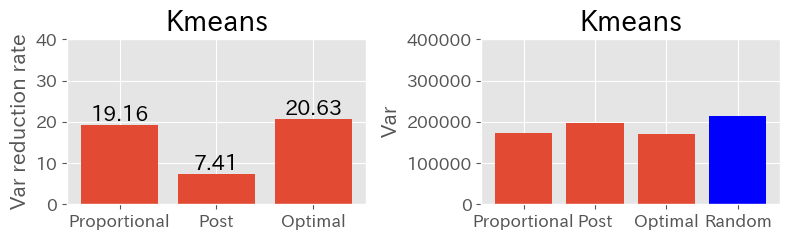

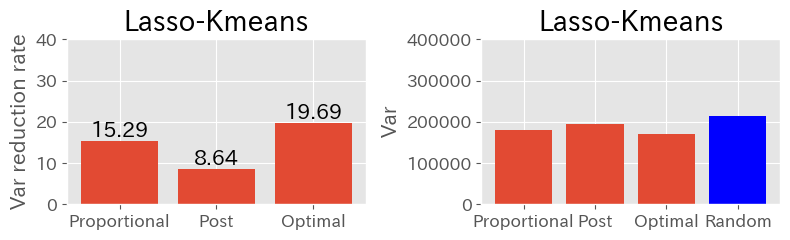

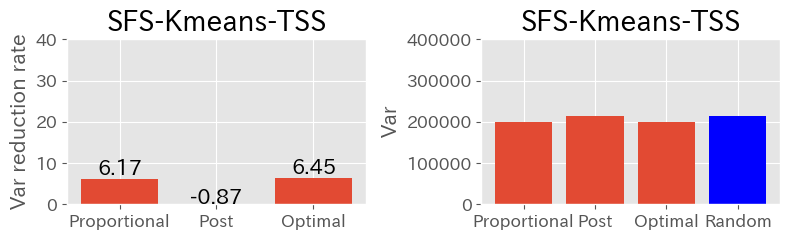

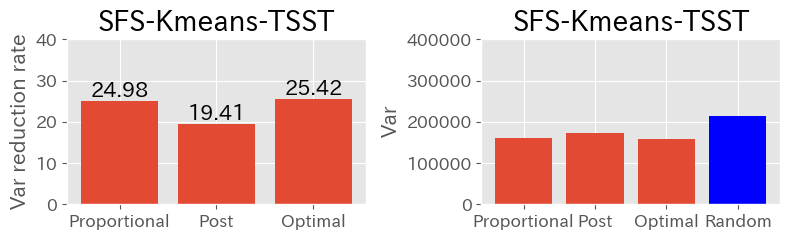

In [52]:
for _, method_name in METHODS_NAME_DICT.items():
    plot_bars(
        dicts=[
            REDUCTION_RATE_DICT_DICT_TRAIN[method_name],
            VAR_STRATIFIED_DICT_DICT_TRAIN[method_name],
        ],
        var_random=VAR_RANDOM_TRAIN,
        target=TARGET,
        method_name=method_name,
        title_size=TITLE_SIZE,
        label_size=LABEL_SIZE,
        tick_size=TICK_SIZE,
    )


### テストデータの結果

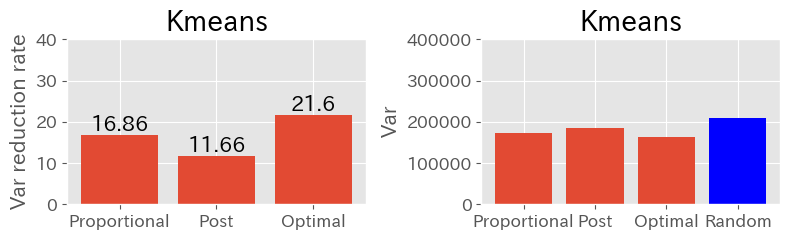

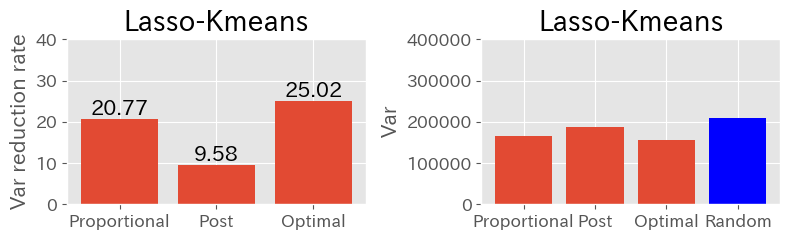

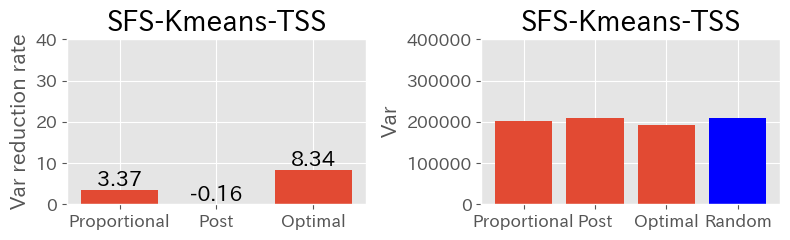

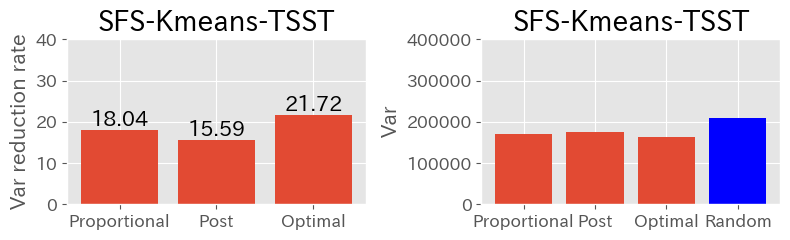

In [53]:
for _, method_name in METHODS_NAME_DICT.items():
    plot_bars(
        dicts=[
            REDUCTION_RATE_DICT_DICT_TEST[method_name],
            VAR_STRATIFIED_DICT_DICT_TEST[method_name],
        ],
        var_random=VAR_RANDOM_TEST,
        target=TARGET,
        method_name=method_name,
        title_size=TITLE_SIZE,
        label_size=LABEL_SIZE,
        tick_size=TICK_SIZE,
    )


In [54]:
print(VAR_RANDOM_TEST)

208604.41171572442
